In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

c:\Users\ADMIN\Documents\Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
train_dir = "../dataset_splits/train"
validation_dir = "../dataset_splits/validation"
test_dir = "../dataset_splits/test"

# Hyperparameters
image_size = 150
batch_size = 32
epochs = 10 #đổi lại nha
learning_rate = 1e-3
num_classes = 6
color_mode = 'grayscale'  
channels = 1  

In [3]:
# Data generators với rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Lưu class names
class_names = list(train_generator.class_indices.keys())

# TÍNH STEPS CHÍNH XÁC TỪ SỐ LƯỢNG SAMPLES
steps_per_epoch = int(np.ceil(train_generator.samples / batch_size))
validation_steps = int(np.ceil(validation_generator.samples / batch_size))
test_steps = int(np.ceil(test_generator.samples / batch_size))

print(f"\nClasses: {class_names}")
print(f"  Mẫu Training:   {train_generator.samples:>5} → {steps_per_epoch:>3} steps")
print(f"  Mẫu Validation: {validation_generator.samples:>5} → {validation_steps:>3} steps")
print(f"  Mẫu Test:       {test_generator.samples:>5} → {test_steps:>3} steps")
print(f"  Color mode:         {color_mode}")
print(f"  Input shape:        ({image_size}, {image_size}, {channels})")

Found 7245 images belonging to 6 classes.
Found 1355 images belonging to 6 classes.
Found 448 images belonging to 6 classes.

Classes: ['0', '1', '2', '3', '4', '5']
  Mẫu Training:    7245 → 227 steps
  Mẫu Validation:  1355 →  43 steps
  Mẫu Test:         448 →  14 steps
  Color mode:         grayscale
  Input shape:        (150, 150, 1)


In [4]:
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(image_size, image_size, channels), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', name='conv4'),
    layers.MaxPooling2D((2, 2), name='pool4'),
    
    # Fully Connected Layers
    layers.Flatten(name='flatten'),
    layers.Dropout(0.65, name='dropout'),
    layers.Dense(128, activation='relu', 
                kernel_regularizer=regularizers.l2(0.002), name='fc1'),
    layers.Dense(num_classes, activation='softmax', name='output')
])

# Hiển thị kiến trúc model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,374 (7.61 MB)

 Trainable params: 1,994,374 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [6]:
callbacks = [
    ModelCheckpoint(
        './saved_model/tomato_grayscale_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Giảm learning rate khi plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Lưu model cuối cùng
model.save('./saved_model/tomato_grayscale_final.h5')

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.3367 - auc: 0.6923 - loss: 1.7303 - precision: 0.5087 - recall: 0.1009
Epoch 1: val_accuracy improved from None to 0.69004, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 1: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 272ms/step - accuracy: 0.4748 - auc: 0.8091 - loss: 1.4277 - precision: 0.7320 - recall: 0.2578 - val_accuracy: 0.6900 - val_auc: 0.9270 - val_loss: 0.9797 - val_precision: 0.7991 - val_recall: 0.5491 - learning_rate: 0.0010
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.6754 - auc: 0.9191 - loss: 1.0223 - precision: 0.7716 - recall: 0.5480
Epoch 2: val_accuracy improved from 0.69004 to 0.75572, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 2: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - accuracy: 0.6919 - auc: 0.9273 - loss: 0.9824 - precision: 0.7808 - recall: 0.5781 - val_accuracy: 0.7557 - val_auc: 0.9533 - val_loss: 0.8317 - val_precision: 0.8344 - val_recall: 0.6583 - learning_rate: 0.0010
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7422 - auc: 0.9487 - loss: 0.8633 - precision: 0.8061 - recall: 0.6557
Epoch 3: val_accuracy improved from 0.75572 to 0.77638, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 3: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 260ms/step - accuracy: 0.7437 - auc: 0.9491 - loss: 0.8623 - precision: 0.8074 - recall: 0.6642 - val_accuracy: 0.7764 - val_auc: 0.9564 - val_loss: 0.8380 - val_precision: 0.8564 - val_recall: 0.6472 - learning_rate: 0.0010
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7771 - auc: 0.9604 - loss: 0.7847 - precision: 0.8299 - recall: 0.7088
Epoch 4: val_accuracy improved from 0.77638 to 0.83616, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 4: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - accuracy: 0.7866 - auc: 0.9647 - loss: 0.7523 - precision: 0.8360 - recall: 0.7282 - val_accuracy: 0.8362 - val_auc: 0.9796 - val_loss: 0.6278 - val_precision: 0.8834 - val_recall: 0.7830 - learning_rate: 0.0010
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8210 - auc: 0.9742 - loss: 0.6639 - precision: 0.8594 - recall: 0.7756
Epoch 5: val_accuracy improved from 0.83616 to 0.83690, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 5: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - accuracy: 0.8182 - auc: 0.9743 - loss: 0.6656 - precision: 0.8590 - recall: 0.7768 - val_accuracy: 0.8369 - val_auc: 0.9799 - val_loss: 0.6213 - val_precision: 0.8696 - val_recall: 0.7970 - learning_rate: 0.0010
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8372 - auc: 0.9796 - loss: 0.6134 - precision: 0.8714 - recall: 0.8032
Epoch 6: val_accuracy improved from 0.83690 to 0.86494, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 6: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - accuracy: 0.8352 - auc: 0.9789 - loss: 0.6218 - precision: 0.8712 - recall: 0.8001 - val_accuracy: 0.8649 - val_auc: 0.9866 - val_loss: 0.5336 - val_precision: 0.8970 - val_recall: 0.8354 - learning_rate: 0.0010
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8511 - auc: 0.9831 - loss: 0.5707 - precision: 0.8864 - recall: 0.8227
Epoch 7: val_accuracy improved from 0.86494 to 0.87011, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 7: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - accuracy: 0.8483 - auc: 0.9819 - loss: 0.5895 - precision: 0.8819 - recall: 0.8192 - val_accuracy: 0.8701 - val_auc: 0.9860 - val_loss: 0.5479 - val_precision: 0.8893 - val_recall: 0.8480 - learning_rate: 0.0010
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8642 - auc: 0.9837 - loss: 0.5681 - precision: 0.8901 - recall: 0.8372
Epoch 8: val_accuracy improved from 0.87011 to 0.87675, saving model to ./saved_model/tomato_grayscale_best.h5



Epoch 8: finished saving model to ./saved_model/tomato_grayscale_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - accuracy: 0.8647 - auc: 0.9845 - loss: 0.5592 - precision: 0.8898 - recall: 0.8403 - val_accuracy: 0.8768 - val_auc: 0.9880 - val_loss: 0.5234 - val_precision: 0.9097 - val_recall: 0.8472 - learning_rate: 0.0010
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8813 - auc: 0.9876 - loss: 0.5105 - precision: 0.9035 - recall: 0.8598
Epoch 9: val_accuracy did not improve from 0.87675
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 215ms/step - accuracy: 0.8763 - auc: 0.9874 - loss: 0.5196 - precision: 0.8974 - recall: 0.8545 - val_accuracy: 0.8760 - val_auc: 0.9867 - val_loss: 0.5338 - val_precision: 0.9060 - val_recall: 0.8539 - learning_rate: 0.0010
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8855 - auc: 0.9896 - loss: 0.4975 - precision: 0.9082 - recall: 0.8693
Epoch 10: val_accuracy did not improve from 0.87675
227/227 ━━━━━━━━━━━━━━━━━━━━

In [8]:
# Evaluate model với số steps chính xác
test_results = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

# Lấy predictions trên toàn bộ tập test
test_generator.reset()
y_pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# LẤY ĐÚNG SỐ LƯỢNG TRUE LABELS
y_true = test_generator.classes[:test_generator.samples]

# KIỂM TRA
print(f"Tổng số mẫu thử nghiệm: {test_generator.samples}")
print(f"Số dự đoán được tạo ra: {len(y_pred)}")
print(f"Số nhãn đúng được thu thập: {len(y_true)}")

# Đảm bảo cắt đúng số lượng
y_pred = y_pred[:test_generator.samples]
y_true = y_true[:test_generator.samples]

# Tính các metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 70)
print("Metrics trên tập test")
print(f"Test Loss:      {test_results[0]:.4f}")
print(f"Test Accuracy:  {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall:    {test_recall*100:.2f}%")
print(f"Test F1-Score:  {test_f1*100:.2f}%")
print(f"Test AUC:       {test_results[4]:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8594 - auc: 0.9881 - loss: 0.5256 - precision: 0.8964 - recall: 0.8304
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Tổng số mẫu thử nghiệm: 448
Số dự đoán được tạo ra: 448
Số nhãn đúng được thu thập: 448

Metrics trên tập test
Test Loss:      0.5256
Test Accuracy:  85.94%
Test Precision: 85.87%
Test Recall:    85.94%
Test F1-Score:  85.31%
Test AUC:       0.9881


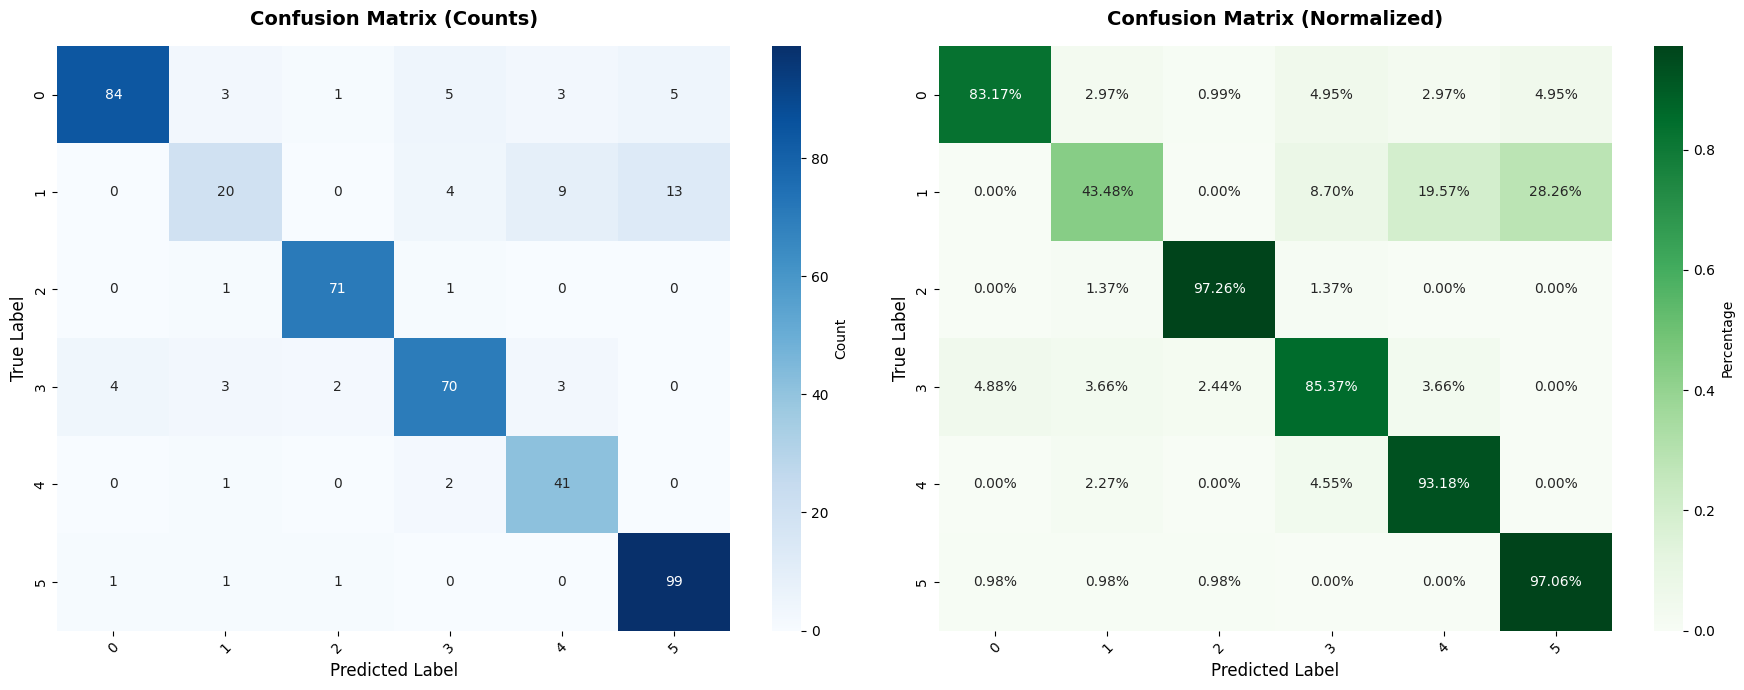

In [9]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Vẽ confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Tính accuracy cho từng class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Confusion Matrix (Count)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Confusion Matrix (Normalized)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Percentage'},
                ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(y_true, y_pred, class_names)

In [10]:
print("Classification Report:")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Tạo DataFrame từ classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nBảng metrics theo từng lớp:")
print(df_report.to_string())

Classification Report:
              precision    recall  f1-score   support

           0     0.9438    0.8317    0.8842       101
           1     0.6897    0.4348    0.5333        46
           2     0.9467    0.9726    0.9595        73
           3     0.8537    0.8537    0.8537        82
           4     0.7321    0.9318    0.8200        44
           5     0.8462    0.9706    0.9041       102

    accuracy                         0.8594       448
   macro avg     0.8353    0.8325    0.8258       448
weighted avg     0.8587    0.8594    0.8531       448


Bảng metrics theo từng lớp:
              precision    recall  f1-score     support
0              0.943820  0.831683  0.884211  101.000000
1              0.689655  0.434783  0.533333   46.000000
2              0.946667  0.972603  0.959459   73.000000
3              0.853659  0.853659  0.853659   82.000000
4              0.732143  0.931818  0.820000   44.000000
5              0.846154  0.970588  0.904110  102.000000
accuracy     

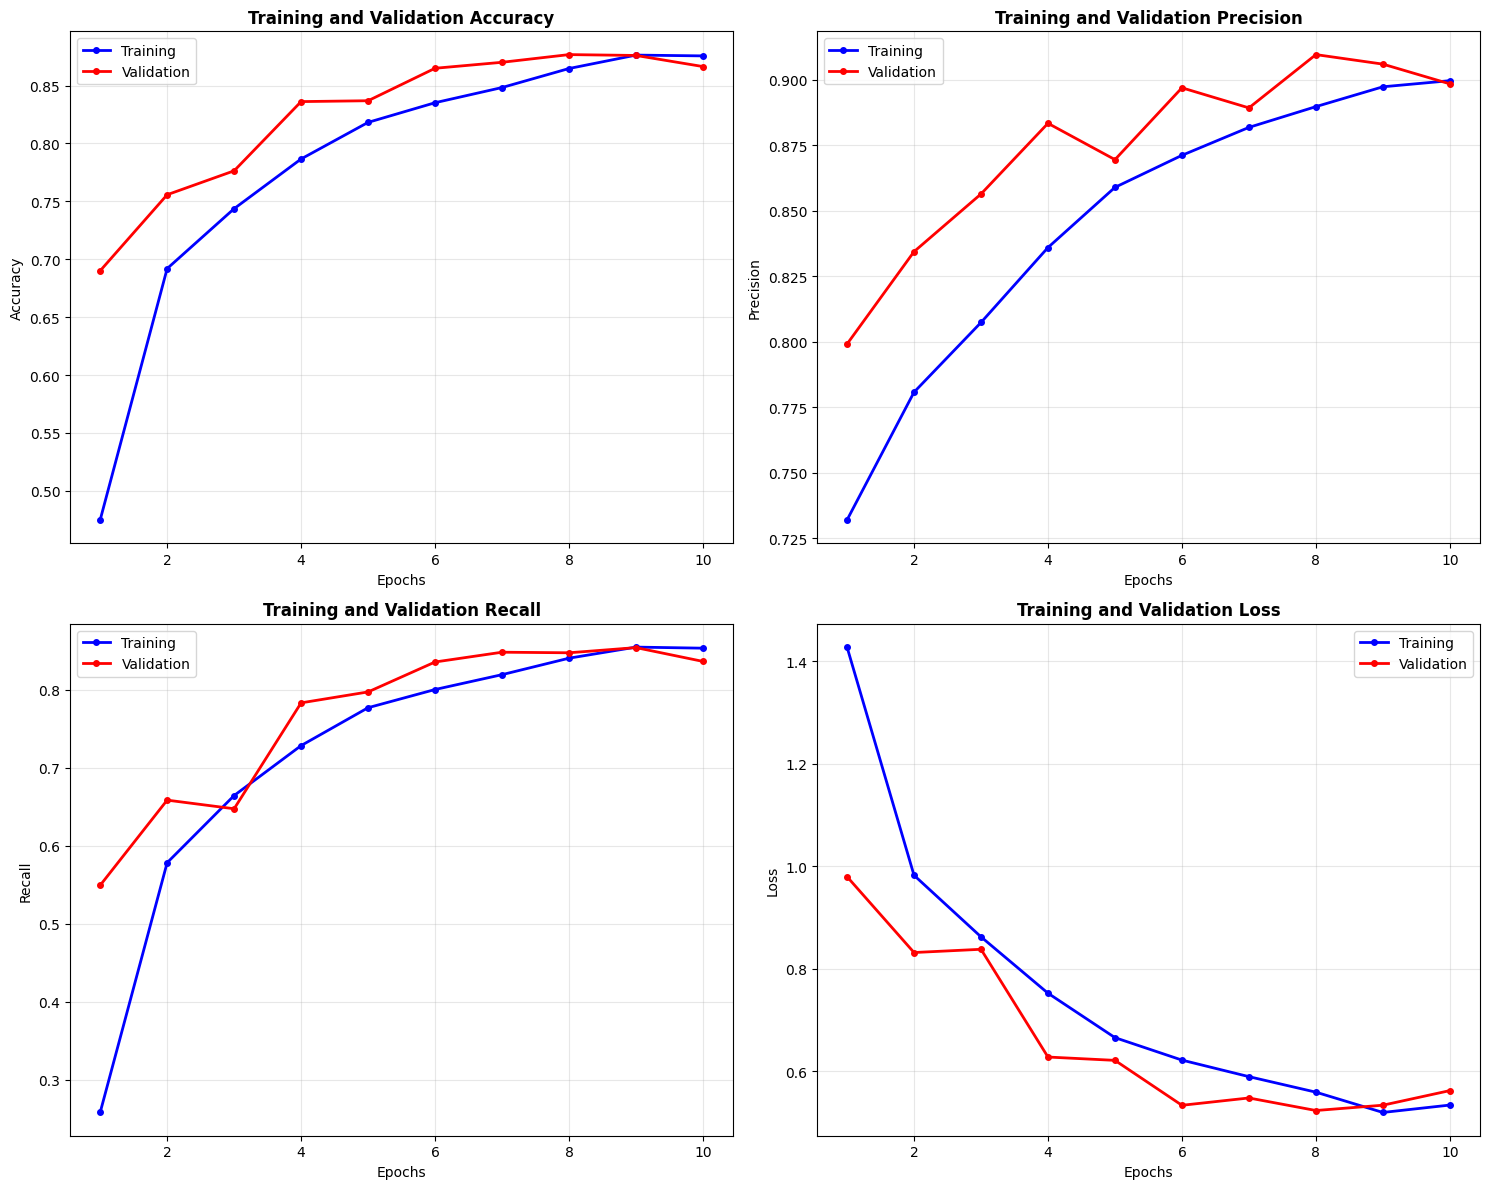


KẾT QUẢ TRAINING CHI TIẾT
Best Training Accuracy:    87.63%
Best Validation Accuracy:  87.68%
Best Training Precision:   89.97%
Best Validation Precision: 90.97%
Best Training Recall:      85.45%
Best Validation Recall:    85.39%
Final Training Loss:       0.5341
Final Validation Loss:     0.5623


In [11]:
def plot_training_history(history):
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'loss']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        if metric == 'loss':
            train_metric = history.history['loss']
            val_metric = history.history['val_loss']
            title = 'Training and Validation Loss'
            ylabel = 'Loss'
        else:
            train_metric = history.history[metric]
            val_metric = history.history[f'val_{metric}']
            title = f'Training and Validation {metric.capitalize()}'
            ylabel = metric.capitalize()
        
        ax.plot(epochs_range, train_metric, 'bo-', label=f'Training', linewidth=2, markersize=4)
        ax.plot(epochs_range, val_metric, 'ro-', label=f'Validation', linewidth=2, markersize=4)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # In thông tin chi tiết
    print("\n" + "=" * 70)
    print("KẾT QUẢ TRAINING CHI TIẾT")
    print("=" * 70)
    print(f"Best Training Accuracy:    {max(history.history['accuracy'])*100:.2f}%")
    print(f"Best Validation Accuracy:  {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Best Training Precision:   {max(history.history['precision'])*100:.2f}%")
    print(f"Best Validation Precision: {max(history.history['val_precision'])*100:.2f}%")
    print(f"Best Training Recall:      {max(history.history['recall'])*100:.2f}%")
    print(f"Best Validation Recall:    {max(history.history['val_recall'])*100:.2f}%")
    print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")

# Vẽ biểu đồ
plot_training_history(history)


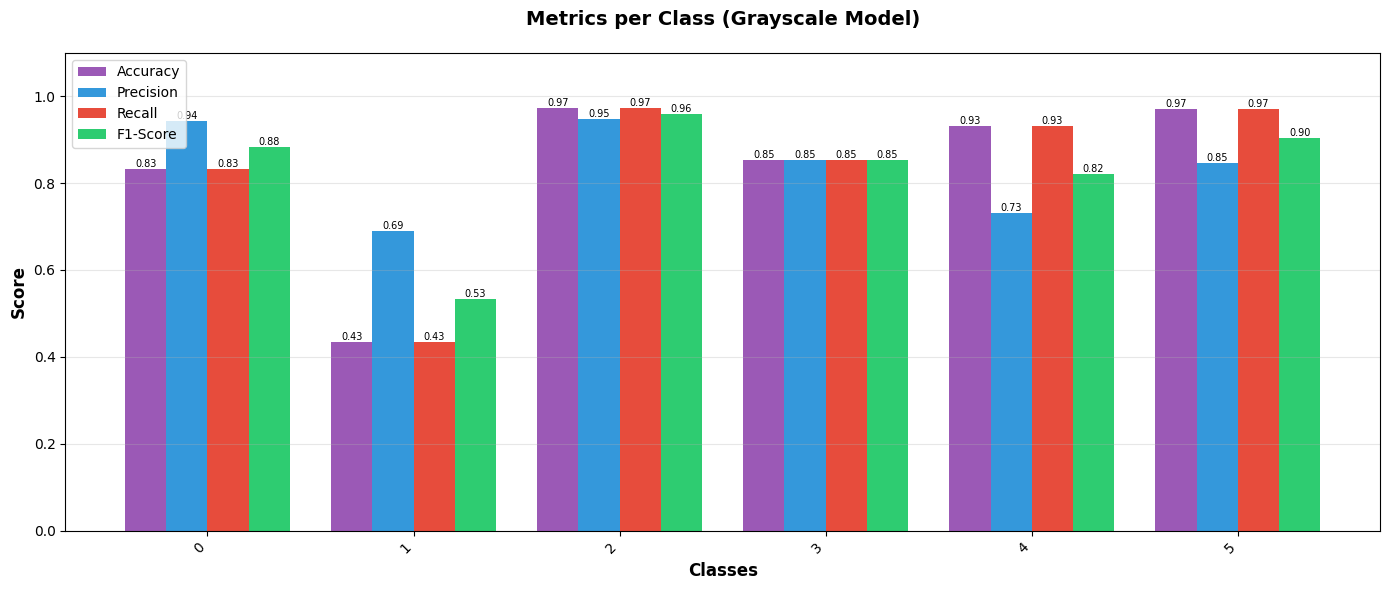


METRICS CHO TỪNG LỚP
Class  Accuracy  Precision   Recall  F1-Score  Support
    0  0.831683   0.943820 0.831683  0.884211      101
    1  0.434783   0.689655 0.434783  0.533333       46
    2  0.972603   0.946667 0.972603  0.959459       73
    3  0.853659   0.853659 0.853659  0.853659       82
    4  0.931818   0.732143 0.931818  0.820000       44
    5  0.970588   0.846154 0.970588  0.904110      102


In [12]:
def plot_metrics_per_class(y_true, y_pred, class_names):
    """Vẽ biểu đồ metrics cho từng class"""
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Tính accuracy per class từ confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    
    x = np.arange(len(class_names))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars1 = ax.bar(x - 1.5*width, accuracy_per_class, width, label='Accuracy', color='#9b59b6')
    bars2 = ax.bar(x - 0.5*width, precision_per_class, width, label='Precision', color='#3498db')
    bars3 = ax.bar(x + 0.5*width, recall_per_class, width, label='Recall', color='#e74c3c')
    bars4 = ax.bar(x + 1.5*width, f1_per_class, width, label='F1-Score', color='#2ecc71')
    
    ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Metrics per Class (Grayscale Model)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    # Thêm giá trị trên các cột
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # In bảng chi tiết
    print("\n" + "=" * 70)
    print("METRICS CHO TỪNG LỚP")
    print("=" * 70)
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': accuracy_per_class,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'Support': cm.sum(axis=1)
    })
    print(metrics_df.to_string(index=False))
    
    return metrics_df

metrics_df = plot_metrics_per_class(y_true, y_pred, class_names)

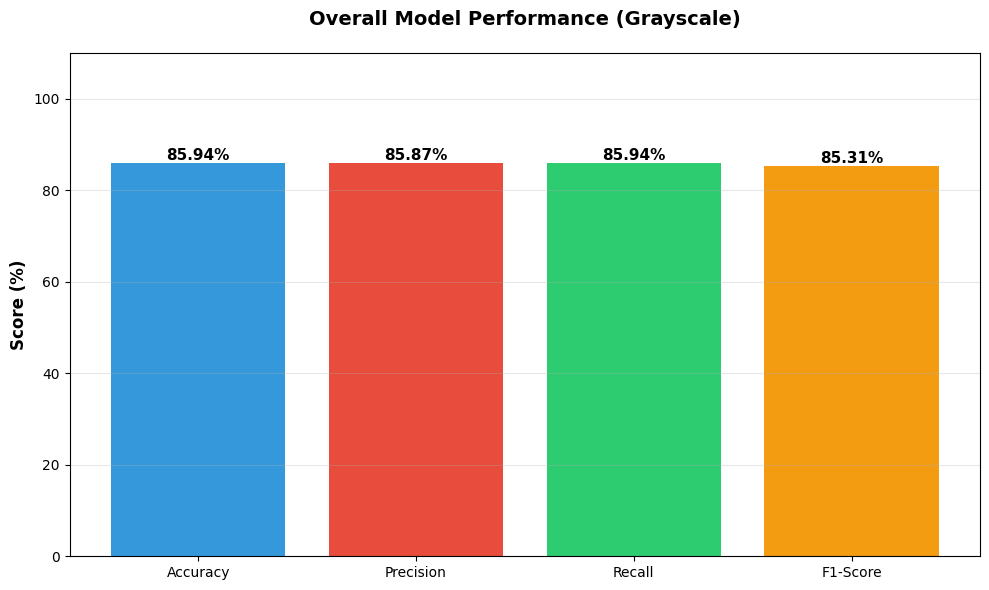

In [13]:
def plot_model_comparison():
    """So sánh các metrics tổng quan"""
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [
        test_results[1] * 100,
        test_precision * 100,
        test_recall * 100,
        test_f1 * 100
    ]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_names, metrics_values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
    
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Model Performance (Grayscale)', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim([0, 110])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Thêm giá trị trên các cột
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}%',
               ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison()

In [14]:
print(f"""
THÔNG TIN MODEL:
- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: {image_size}x{image_size}x{channels} (Grayscale)
- Số lớp phân loại: {num_classes}

DATASET:
- Training samples:   {train_generator.samples:>5} ({steps_per_epoch} steps/epoch)
- Validation samples: {validation_generator.samples:>5} ({validation_steps} steps)
- Test samples:       {test_generator.samples:>5} ({test_steps} steps)
- Classes: {class_names}

HYPERPARAMETERS:
- Learning rate: {learning_rate}
- Batch size: {batch_size}
- Epochs trained: {len(history.history['loss'])} / {epochs}
- Optimizer: Adam
- Loss function: Categorical Crossentropy

REGULARIZATION:
- Dropout: 0.65
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

KẾT QUẢ TRAINING:
- Final Training Accuracy:    {history.history['accuracy'][-1]*100:.2f}%
- Final Training Precision:   {history.history['precision'][-1]*100:.2f}%
- Final Training Recall:      {history.history['recall'][-1]*100:.2f}%
- Final Validation Accuracy:  {history.history['val_accuracy'][-1]*100:.2f}%
- Final Validation Precision: {history.history['val_precision'][-1]*100:.2f}%
- Final Validation Recall:    {history.history['val_recall'][-1]*100:.2f}%

KẾT QUẢ TEST (trên {test_generator.samples} samples):
- Test Accuracy:  {test_results[1]*100:.2f}%
- Test Precision: {test_precision*100:.2f}%
- Test Recall:    {test_recall*100:.2f}%
- Test F1-Score:  {test_f1*100:.2f}%
- Test AUC:       {test_results[4]:.4f}
- Test Loss:      {test_results[0]:.4f}""")


THÔNG TIN MODEL:
- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: 150x150x1 (Grayscale)
- Số lớp phân loại: 6

DATASET:
- Training samples:    7245 (227 steps/epoch)
- Validation samples:  1355 (43 steps)
- Test samples:         448 (14 steps)
- Classes: ['0', '1', '2', '3', '4', '5']

HYPERPARAMETERS:
- Learning rate: 0.001
- Batch size: 32
- Epochs trained: 10 / 10
- Optimizer: Adam
- Loss function: Categorical Crossentropy

REGULARIZATION:
- Dropout: 0.65
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

KẾT QUẢ TRAINING:
- Final Training Accuracy:    87.56%
- Final Training Precision:   89.97%
- Final Training Recall:      85.31%
- Final Validation Accuracy:  86.64%
- Final Validation Precision: 89.85%
- Final Validation Recall:    83.62%

KẾT QUẢ TEST (trên 448 samples):
- Test Accuracy:  85.94%
- Test Precision: 85.87%
- Test Recall:    85.94%
- Test F1-Score:  85.31%
- Test AUC:       0.9881
- Test Loss:      0.525